# Clusters with a Gaussian Matrix

In [1]:
import sys

assert sys.version_info >= (3, 7)
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

from pathlib import Path
    
from sklearn.datasets import make_blobs
import numpy as np

Clustering is a technique used to help us find trends in complex data sets that might be hard to identify manually. With the help of machine learning techniques such as DBScan, KMeans, Gausian Matrix and others we can group the data into clusters that we can then work to interpret. Classifcation is another technique that also breaks up data sets into distinct groups based on different criteria, but with classification there tends to be groups we are setting out to fit the data into. Clustering on the other hand works with data that we have little to no information about before we start working with. With clustering the goal is to look at the clusters and figure out what seperates on cluster from another. 

For example clustering might be used to help inform an e-commerce site on what they may want to add or adjust based on the tendencies of current customers. They could take the purchase history or viewing history of users and generate clusters. From there, they can analyze them to see if there is specific interest in a certain types of products. From there they could better design their website to meet the needs of their customers.

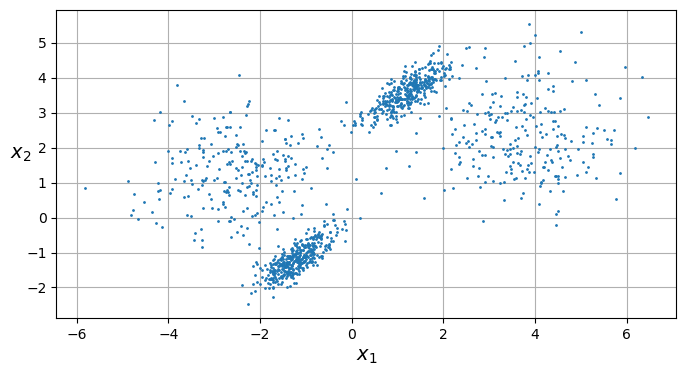

In [2]:
X1, y1 = make_blobs(n_samples=750, centers=((-2, 10), (-2, -2)), random_state=27)

X1 = X1.dot(np.array([[0.4, 0.2], [0.2, 0.4]]))
X2, y2 = make_blobs(n_samples=500, centers=2, random_state=27)
X2 = X2 + [-1, -5]
X = np.r_[X1, X2]
y = np.r_[y1, y2]


def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.gca().set_axisbelow(True)
plt.grid()
plt.show()

To help demonstrate what the process of using a clustering technique might look like I have generated some data using sklearn's make_blobs function. This data is completely meaningless, but that with clustering that is completely fine. By looking at the plot of the data we can pretty easily see that there are 4 clusters to consider. Two of them are rather closely packed and two are rather spread out. 

When considering what clustering technque there are three that came to mind: KMeans, dbscan, and Gaussian Matrix. KMeans would struggle with this particular data set because two of the clusters are not normal or circular. Dbscan would also struggle due to the rather spread out nature of the other two clusters. Gaussian matrix though should be able to deal with this data set well as it is not anticipating the clusters being circular and not based on the distance seperating one specific data point from another. As a result, I will be using a gaussian matrix to help assign clusters and demonstrate this technique. 

There are two main criteria that we want to give to the program in order to set up the gaussian matrix: number of mixture components and the number of initilizations to perform. There are other parameters we can set such as the convariance type, but for this particular data set the defaults for this should be good. 

The number of mixture components should match out expected number of clusters. Given that there are pretty clearly four distinct clusters we could just use four for the number of mixture components. However, we can also plot either the Bayesian Information Criterion (BIC) or Akaike Information Criterion (AIC) across multiple different values to figure out what this value should be.
********* MORE HERE FOR THE CALCS ************

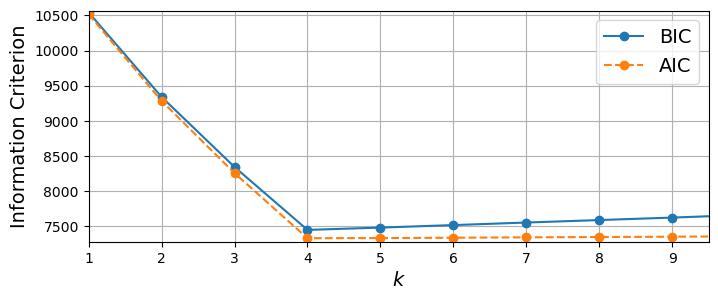

In [3]:
from sklearn.mixture import GaussianMixture
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "o-", label="BIC")
plt.plot(range(1, 11), aics, "o--", label="AIC")
plt.xlabel("$k$")
plt.ylabel("Information Criterion")
plt.axis([1, 9.5, min(aics) - 50, max(aics) + 50])
plt.legend()
plt.grid()
plt.show()

In this case, I have used sklearn in order to calculate these statistics, but the actual formulas for this are as follows:

BIC = k ln(n) - 2 ln(L)
AIC = 2 k  - 2 ln(L)

L is the maximum value of the likelihood function for the model
k is the number of estimated parameters in the model
n is the sample size

By looking at the minimum point on either of these lines, we can see that a value of four for the number of mixture components would be best. This helps us to reduce the chance of potentially overfitting the model which would make it harder for us to interpret results accurately. 

For now, we will just use ten for the number of initilizations, but this can be varied to see how the results turn out best later. With this input we can go ahead and fit a matrix to the data and plot the results using the sklearn and matplotlib libraries. 

In [6]:
gm = GaussianMixture(n_components=4, n_init=10, random_state=27)
gm.fit(X)

GaussianMixture(n_components=4, n_init=10, random_state=27)

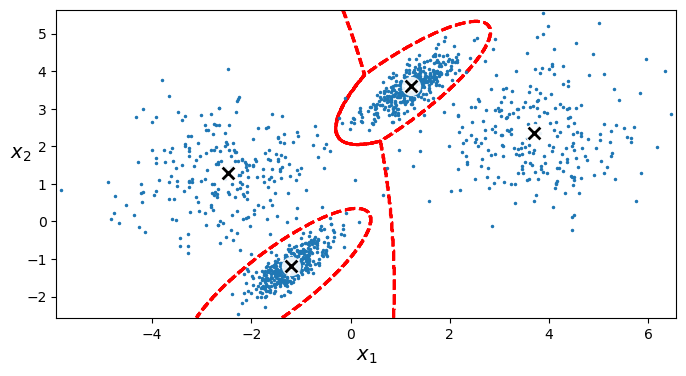

In [7]:
from matplotlib.colors import LogNorm

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], '.', markersize=3)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$")
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

Once we have fit the data we can go ahead and plot it again along with the centroids and decision boundries the algorithm came up with. Now, we can see that the algorithm did a very good job of fitting to the four distinct clusters. We can see the red dashed lines around each of the more densely packed clusters and the boundry between the two more sparsely packed clusters. From this, we can start analyzing the clusters to see distinct similariets between the groups. 

For example, if this data was the search habits of different users on an online pharmacy we might be able to see that distinct age ranges are interested in certain products. This might give us the idea to potentially break up products based on age. I we were using some sort of dimendionality reduction then maybe we could see that other factors may impact interest such as weight or gender, but that will have to wait till a later blog post. 